In [1]:
%matplotlib inline

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [3]:
import os
from astropy.table import Table

#  MDPL2-based mock
dirname = "/Users/aphearin/work/random/0331"
basename = "cutmock_1e9.hdf5"
fname = os.path.join(dirname, basename)
mock = Table.read(fname, path='data')
mock.Lbox = 500.

#  Bpl-based mock
# dirname = "/Users/aphearin/work/random/0331"
# basename = "testing_bpl_based_v4.hdf5"
# fname = os.path.join(dirname, basename)
# mock = Table.read(fname, path='data')
# mock.Lbox = 250.

print(mock.keys())

['halo_id', 'upid', 'vpeak', 'mpeak', 'mvir', 'vmax', 'sm', 'sfr', 'obs_sm', 'obs_sfr', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'hostid', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sfr_percentile', 'sfr_percentile']


## Map $M_{\rm g}, M_{\rm r}, M_{\rm i}$ onto every galaxy based on its $M_{\ast}$ and ${\rm SFR}$-percentile

In [4]:
from time import time 
from cosmodc2.sdss_colors import assign_restframe_sdss_gri

upid_mock = mock['upid']
mstar_mock = mock['obs_sm']
sfr_percentile_mock = mock['sfr_percentile']
host_halo_mvir_mock = mock['host_halo_mvir']
redshift_mock = np.zeros(len(mock)) + 0.0

# logmstar_sdss = sdss['sm']
# sfr_percentile_sdss = sdss['sfr_percentile_fixed_sm']
# sdss_magr = sdss['restframe_extincted_sdss_abs_magr']
# sdss_redshift = sdss['z']

start = time()
magr, gr_mock, ri_mock = assign_restframe_sdss_gri(
    upid_mock, mstar_mock, sfr_percentile_mock, host_halo_mvir_mock, redshift_mock)
end = time()
mock['restframe_extincted_sdss_abs_magr'] = magr
mock['restframe_extincted_sdss_gr'] = gr_mock
mock['restframe_extincted_sdss_ri'] = ri_mock

print("Runtime to assign gri = {0:.1f} seconds".format(end-start))

Runtime to assign gri = 28.8 seconds


## Compare cumulative number density to Zehavi+11

In [5]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd

volume_v4 = mock.Lbox**3.
protoDC2_littleh = 0.7
cumnd_pdc2_v4 = cumulative_nd(mock['restframe_extincted_sdss_abs_magr'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)


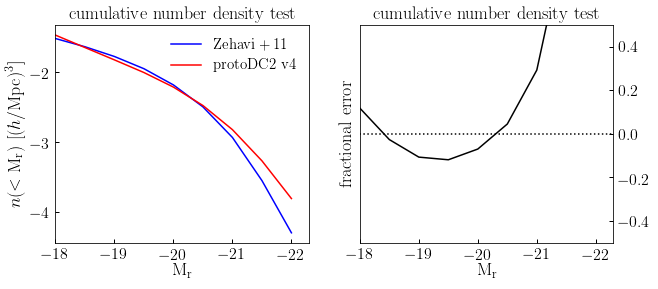

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_sdss), label=r'${\rm Zehavi+11}$', color='blue')
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4), 
            label=r'${\rm protoDC2\ v4}$', color='red')

fracdiff_pdc2_v4 = (cumnd_pdc2_v4 - cumnd_sdss)/cumnd_sdss

__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4, 
            label=r'${\rm protoDC2\ v4}$', color='k')
__=ax2.plot(np.linspace(-100, 100, 100), np.zeros(100), ':', color='k')

legend = ax1.legend()
xlabel = ax1.set_xlabel(r'${\rm M_{r}}$')
xlabel2 = ax2.set_xlabel(r'${\rm M_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm fractional\ error}$')
ylabel = ax1.set_ylabel(r'$n(<{\rm M_r})\ [(h/{\rm Mpc})^3]$')
title1 = ax1.set_title(r'${\rm cumulative\ number\ density\ test}$')
title2 = ax2.set_title(r'${\rm cumulative\ number\ density\ test}$')
ax2.yaxis.tick_right()  
xlim1 = ax1.set_xlim(-18, -22.3)
ylim2 = ax2.set_ylim(-0.5, 0.5)

figname = 'luminosity_function_pdc2_v4_vs_zehavi11.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

## Compare luminosity threshold clustering to Zehavi+11

In [7]:
from cosmodc2.mock_diagnostics import zehavi_wp

period = mock.Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['restframe_extincted_sdss_abs_magr']

rp_mids, wp_v4_19p0 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh)
rp_mids, wp_v4_19p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh)
rp_mids, wp_v4_20p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh)
rp_mids, wp_v4_21p5 = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh)


...calculating wp for 3.99e+05 galaxies and Mr < -19.0
...calculating wp for 4.00e+05 galaxies and Mr < -19.5
...calculating wp for 4.00e+05 galaxies and Mr < -20.5
...calculating wp for 6.71e+04 galaxies and Mr < -21.5


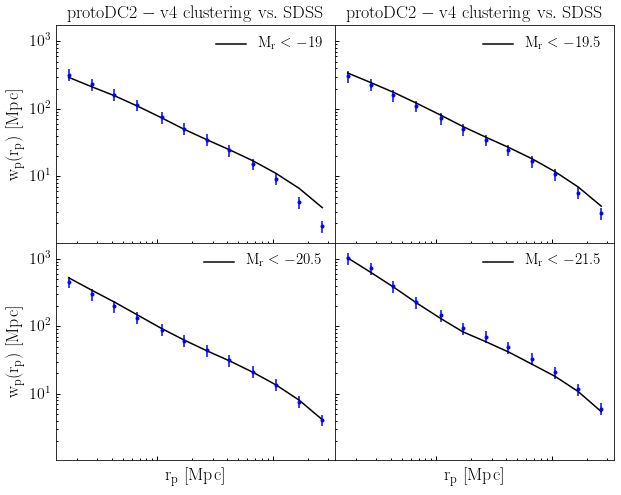

In [8]:
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi
from cosmodc2.sdss_colors import zehavi11_clustering

wp_zehavi_18p5 = zehavi11_clustering(-18.5)
wp_zehavi_19p0 = zehavi11_clustering(-19.0)
wp_zehavi_19p5 = zehavi11_clustering(-19.5)
wp_zehavi_20p0 = zehavi11_clustering(-20.0)
wp_zehavi_20p5 = zehavi11_clustering(-20.5)
wp_zehavi_21p0 = zehavi11_clustering(-21.0)
wp_zehavi_21p5 = zehavi11_clustering(-21.5)

fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()


__=ax1.plot(rp_mids, wp_v4_19p0,  color='k', label=r'${\rm M_{r} < -19}$')
__=ax1.errorbar(rp_zehavi, wp_zehavi_19p0, 0.2*wp_zehavi_19p0, 
               fmt='.', color='blue')

__=ax2.plot(rp_mids, wp_v4_19p5,  color='k', label=r'${\rm M_{r} < -19.5}$')
__=ax2.errorbar(rp_zehavi, wp_zehavi_19p5, 0.2*wp_zehavi_19p5, 
               fmt='.', color='blue')

__=ax3.plot(rp_mids, wp_v4_20p5,  color='k', label=r'${\rm M_{r} < -20.5}$')
__=ax3.errorbar(rp_zehavi, wp_zehavi_20p5, 0.2*wp_zehavi_20p5, 
               fmt='.', color='blue')

__=ax4.plot(rp_mids, wp_v4_21p5,  color='k', label=r'${\rm M_{r} < -21.5}$')
__=ax4.errorbar(rp_zehavi, wp_zehavi_21p5, 0.2*wp_zehavi_21p5, 
               fmt='.', color='blue')

for ax in axes:
    leg = ax.legend()

title1 = ax1.set_title(r'${\rm protoDC2-v4\ clustering\ vs.\ SDSS}$')
title2 = ax2.set_title(r'${\rm protoDC2-v4\ clustering\ vs.\ SDSS}$')

xlabel3 = ax3.set_xlabel(r'${\rm r_p\ [Mpc]}$')
xlabel4 = ax4.set_xlabel(r'${\rm r_p\ [Mpc]}$')
ylabel1 = ax1.set_ylabel(r'${\rm w_p(r_p)\ [Mpc]}$')
ylabel3 = ax3.set_ylabel(r'${\rm w_p(r_p)\ [Mpc]}$')

__=ax1.set_xticklabels([''])
__=ax2.set_xticklabels([''])

figname = 'luminosity_dependent_clustering_pdc2_v4_vs_zehavi11.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

Well that looks good in a log-log plot, so let's look at $r_{\rm p}\times w_{\rm p}$ to bring out the discrepancies.

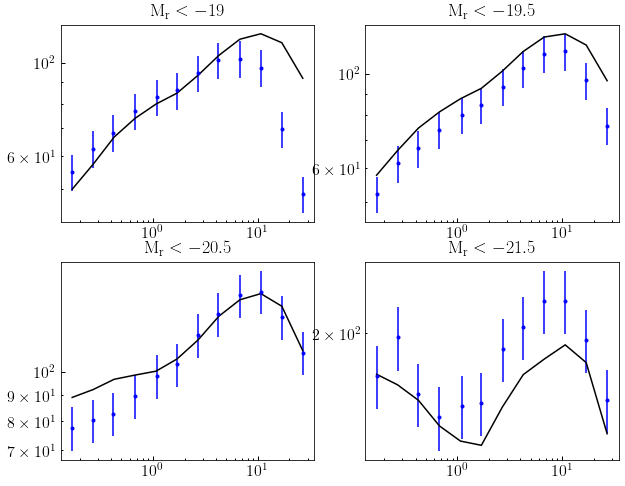

In [9]:
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi
from cosmodc2.sdss_colors import zehavi11_clustering

wp_zehavi_18p5 = zehavi11_clustering(-18.5)
wp_zehavi_19p0 = zehavi11_clustering(-19.0)
wp_zehavi_19p5 = zehavi11_clustering(-19.5)
wp_zehavi_20p0 = zehavi11_clustering(-20.0)
wp_zehavi_20p5 = zehavi11_clustering(-20.5)
wp_zehavi_21p0 = zehavi11_clustering(-21.0)
wp_zehavi_21p5 = zehavi11_clustering(-21.5)

fig, _axes = plt.subplots(2, 2, figsize=(10, 8))
((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()


fake_error = 0.1
__=ax1.plot(rp_mids, rp_mids*wp_v4_19p0,  color='k')
__=ax1.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_19p0, rp_zehavi*fake_error*wp_zehavi_19p0, 
               fmt='.', color='blue')

__=ax2.plot(rp_mids, rp_mids*wp_v4_19p5,  color='k')
__=ax2.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_19p5, rp_zehavi*fake_error*wp_zehavi_19p5, 
               fmt='.', color='blue')

__=ax3.plot(rp_mids, rp_mids*wp_v4_20p5,  color='k')
__=ax3.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_20p5, rp_zehavi*fake_error*wp_zehavi_20p5, 
               fmt='.', color='blue')

__=ax4.plot(rp_mids, rp_mids*wp_v4_21p5,  color='k')
__=ax4.errorbar(rp_zehavi, rp_zehavi*wp_zehavi_21p5, rp_zehavi*fake_error*wp_zehavi_21p5, 
               fmt='.', color='blue')


title1 = ax1.set_title(r'${\rm M_{r} < -19}$')
title2 = ax2.set_title(r'${\rm M_{r} < -19.5}$')
title3 = ax3.set_title(r'${\rm M_{r} < -20.5}$')
title4 = ax4.set_title(r'${\rm M_{r} < -21.5}$')


Large-scale clustering is too strong at the faint end, and the one-to-two halo transition is too weak at the bright end; otherwise, looks pretty good. 

## Inspect the CLF

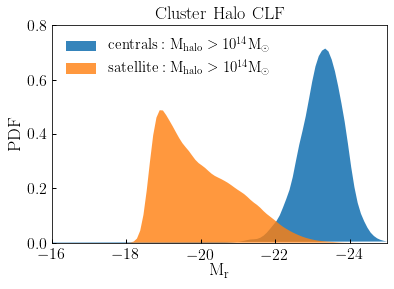

In [10]:
cenmask = mock['upid'] == -1
lowm, highm = 14., np.inf
halo_mask = (mock['host_halo_mvir'] > 10**lowm) & (mock['host_halo_mvir'] < 10**highm)

num_clusters = np.count_nonzero(cenmask & halo_mask)

fig, ax = plt.subplots(1, 1)

from scipy.stats import gaussian_kde
kde_sats = gaussian_kde(mock['restframe_extincted_sdss_abs_magr'][halo_mask & ~cenmask])
kde_cens = gaussian_kde(mock['restframe_extincted_sdss_abs_magr'][halo_mask & cenmask])

x = np.linspace(-12, -25, 150)
sats_pdf = kde_sats.evaluate(x)
cens_pdf = kde_cens.evaluate(x)

__=ax.fill(x, cens_pdf, alpha=0.9, 
           label=r'${\rm centrals: M_{halo} > 10^{14}M_{\odot}}$')
__=ax.fill(x, sats_pdf, alpha=0.8, 
           label=r'${\rm satellite: M_{halo} > 10^{14}M_{\odot}}$')

legend = ax.legend(loc='upper left')

ylim = ax.set_ylim(0, 0.8)
xlim = ax.set_xlim(-16, -25)
xlabel = ax.set_xlabel(r'${\rm M_{\rm r}}$')
ylabel = ax.set_ylabel(r'${\rm PDF}$')
title = ax.set_title(r'${\rm Cluster\ Halo\ CLF}$')

figname = 'cluster_halo_clf_v4.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

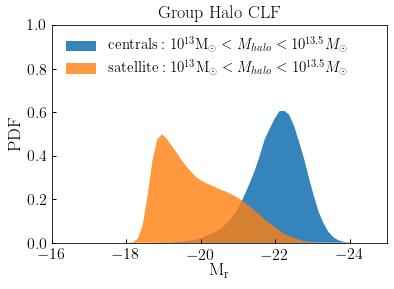

In [11]:
cenmask = mock['upid'] == -1
lowm, highm = 13., 13.5
halo_mask = (mock['host_halo_mvir'] > 10**lowm) & (mock['host_halo_mvir'] < 10**highm)

num_clusters = np.count_nonzero(cenmask & halo_mask)

fig, ax = plt.subplots(1, 1)

from scipy.stats import gaussian_kde
kde_sats = gaussian_kde(mock['restframe_extincted_sdss_abs_magr'][halo_mask & ~cenmask])
kde_cens = gaussian_kde(mock['restframe_extincted_sdss_abs_magr'][halo_mask & cenmask])

x = np.linspace(-12, -25, 100)
sats_pdf = kde_sats.evaluate(x)
cens_pdf = kde_cens.evaluate(x)

__=ax.fill(x, cens_pdf, alpha=0.9, 
           label=r'${\rm centrals: 10^{13}M_{\odot}} < M_{halo} < 10^{13.5}M_{\odot}}$')
__=ax.fill(x, sats_pdf, alpha=0.8, 
           label=r'${\rm satellite: 10^{13}M_{\odot}} < M_{halo} < 10^{13.5}M_{\odot}}$')

legend = ax.legend(loc='upper left')

ylim = ax.set_ylim(0, 1)
xlim = ax.set_xlim(-16, -25)
xlabel = ax.set_xlabel(r'${\rm M_{\rm r}}$')
ylabel = ax.set_ylabel(r'${\rm PDF}$')
title = ax.set_title(r'${\rm Group\ Halo\ CLF}$')

figname = 'group_halo_clf_v4.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

## $\langle M_{\ast}\vert M_{\rm halo}\rangle$ relation

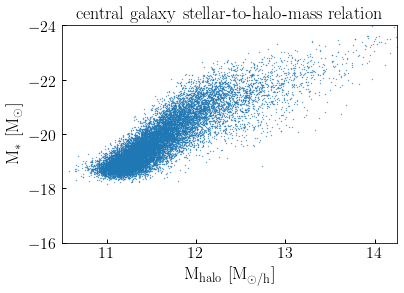

In [12]:
fig, ax = plt.subplots(1, 1)

cenmask = mock['upid'] == -1
num_cens = np.count_nonzero(cenmask)
nskip = 200
__=ax.scatter(np.log10(mock['mpeak'][cenmask][::nskip]), 
              mock['restframe_extincted_sdss_abs_magr'][cenmask][::nskip],
             s=0.1)

ylim = ax.set_ylim(-16, -24)
xlim = ax.set_xlim(10.5, 14.25)

xlabel = ax.set_xlabel(r'${\rm M_{\rm halo}\ [M_{\odot/h}]}$')
ylabel = ax.set_ylabel(r'${\rm M_{\ast}\ [M_{\odot}]}$')
title = ax.set_title(r'${\rm central\ galaxy\ stellar}$-${\rm to}$-${\rm halo}$-${\rm mass\ relation}$')
figname = 'mass_to_light_centrals_v4.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

##  Compare color one-point functions in mock to SDSS

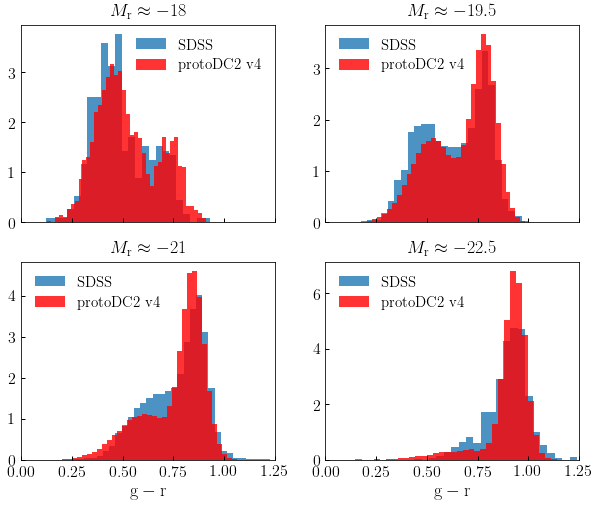

In [13]:
npts = int(1e6)

from cosmodc2.sdss_colors.sdss_completeness_model import retrieve_sdss_sample_mask

magr_max = -18.
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_gr18 = sdss['restframe_extincted_sdss_gr'][mask]
mock_mask = (mock['restframe_extincted_sdss_abs_magr'] < magr_max)
mock_mask *= (mock['restframe_extincted_sdss_abs_magr'] > magr_min)
mock_sample_gr18 = mock['restframe_extincted_sdss_gr'][mock_mask]

magr_max = -19.5
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_gr19p5 = sdss['restframe_extincted_sdss_gr'][mask]
mock_mask = (mock['restframe_extincted_sdss_abs_magr'] < magr_max)
mock_mask *= (mock['restframe_extincted_sdss_abs_magr'] > magr_min)
mock_sample_gr19p5 = mock['restframe_extincted_sdss_gr'][mock_mask]

magr_max = -21.
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_gr21 = sdss['restframe_extincted_sdss_gr'][mask]
mock_mask = (mock['restframe_extincted_sdss_abs_magr'] < magr_max)
mock_mask *= (mock['restframe_extincted_sdss_abs_magr'] > magr_min)
mock_sample_gr21 = mock['restframe_extincted_sdss_gr'][mock_mask]

magr_max = -22.5
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_gr22p5 = sdss['restframe_extincted_sdss_gr'][mask]
mock_mask = (mock['restframe_extincted_sdss_abs_magr'] < magr_max)
mock_mask *= (mock['restframe_extincted_sdss_abs_magr'] > magr_min)
mock_sample_gr22p5 = mock['restframe_extincted_sdss_gr'][mock_mask]


fig, _axes = plt.subplots(2, 2, figsize=(10, 8))

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4

nbins = 40

__=ax1.hist(sdss_sample_gr18, bins=nbins, alpha=0.8, normed=True, label=r'${\rm SDSS}$')
__=ax1.hist(mock_sample_gr18, bins=nbins, alpha=0.8, normed=True, 
            color='red', label=r'${\rm protoDC2\ v4}$')

__=ax2.hist(sdss_sample_gr19p5, bins=nbins, alpha=0.8, normed=True, label=r'${\rm SDSS}$')
__=ax2.hist(mock_sample_gr19p5, bins=nbins, alpha=0.8, normed=True, 
            color='red', label=r'${\rm protoDC2\ v4}$')

__=ax3.hist(sdss_sample_gr21, bins=nbins, alpha=0.8, normed=True, label=r'${\rm SDSS}$')
__=ax3.hist(mock_sample_gr21, bins=nbins, alpha=0.8, normed=True, 
            color='red', label=r'${\rm protoDC2\ v4}$')

__=ax4.hist(sdss_sample_gr22p5, bins=nbins, alpha=0.8, normed=True, label=r'${\rm SDSS}$')
__=ax4.hist(mock_sample_gr22p5, bins=nbins, alpha=0.8, normed=True, 
            color='red', label=r'${\rm protoDC2\ v4}$')

for ax in axes:
    xlim = ax.set_xlim(0, 1.25)
    leg = ax.legend()

ax1.set_xticklabels([''])
ax2.set_xticklabels([''])
title1 = ax1.set_title(r'$M_{\rm r} \approx -18$')
title2 = ax2.set_title(r'$M_{\rm r} \approx -19.5$')
title3 = ax3.set_title(r'$M_{\rm r} \approx -21$')
title4 = ax4.set_title(r'$M_{\rm r} \approx -22.5$')
xlabel3 = ax3.set_xlabel(r'${\rm g-r}$')
xlabel4 = ax4.set_xlabel(r'${\rm g-r}$')

figname = 'sdss_gr_distribution_vs_pdc2v4.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3], bbox_inches='tight')

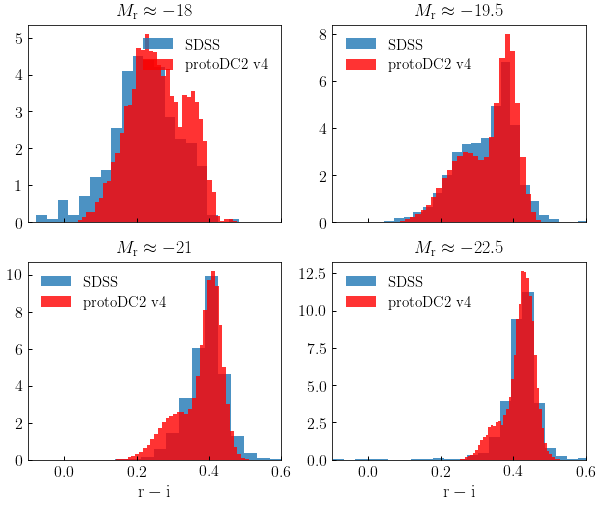

In [14]:
npts = int(1e6)

from cosmodc2.sdss_colors.sdss_completeness_model import retrieve_sdss_sample_mask

magr_max = -18.
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_ri18 = sdss['restframe_extincted_sdss_ri'][mask]
mock_mask = (mock['restframe_extincted_sdss_abs_magr'] < magr_max)
mock_mask *= (mock['restframe_extincted_sdss_abs_magr'] > magr_min)
mock_sample_ri18 = mock['restframe_extincted_sdss_ri'][mock_mask]

magr_max = -19.5
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_ri19p5 = sdss['restframe_extincted_sdss_ri'][mask]
mock_mask = (mock['restframe_extincted_sdss_abs_magr'] < magr_max)
mock_mask *= (mock['restframe_extincted_sdss_abs_magr'] > magr_min)
mock_sample_ri19p5 = mock['restframe_extincted_sdss_ri'][mock_mask]

magr_max = -21.
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_ri21 = sdss['restframe_extincted_sdss_ri'][mask]
mock_mask = (mock['restframe_extincted_sdss_abs_magr'] < magr_max)
mock_mask *= (mock['restframe_extincted_sdss_abs_magr'] > magr_min)
mock_sample_ri21 = mock['restframe_extincted_sdss_ri'][mock_mask]

magr_max = -22.5
magr_min = magr_max - 0.3
mask = retrieve_sdss_sample_mask(
    sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], magr_min, magr_max)
sdss_sample_ri22p5 = sdss['restframe_extincted_sdss_ri'][mask]
mock_mask = (mock['restframe_extincted_sdss_abs_magr'] < magr_max)
mock_mask *= (mock['restframe_extincted_sdss_abs_magr'] > magr_min)
mock_sample_ri22p5 = mock['restframe_extincted_sdss_ri'][mock_mask]


fig, _axes = plt.subplots(2, 2, figsize=(10, 8))

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4

nbins = 40

__=ax1.hist(sdss_sample_ri18, bins=nbins, alpha=0.8, normed=True, label=r'${\rm SDSS}$')
__=ax1.hist(mock_sample_ri18, bins=nbins, alpha=0.8, normed=True, 
            color='red', label=r'${\rm protoDC2\ v4}$')

__=ax2.hist(sdss_sample_ri19p5, bins=nbins, alpha=0.8, normed=True, label=r'${\rm SDSS}$')
__=ax2.hist(mock_sample_ri19p5, bins=nbins, alpha=0.8, normed=True, 
            color='red', label=r'${\rm protoDC2\ v4}$')

__=ax3.hist(sdss_sample_ri21, bins=nbins, alpha=0.8, normed=True, label=r'${\rm SDSS}$')
__=ax3.hist(mock_sample_ri21, bins=nbins, alpha=0.8, normed=True, 
            color='red', label=r'${\rm protoDC2\ v4}$')

__=ax4.hist(sdss_sample_ri22p5, bins=nbins, alpha=0.8, normed=True, label=r'${\rm SDSS}$')
__=ax4.hist(mock_sample_ri22p5, bins=nbins, alpha=0.8, normed=True, 
            color='red', label=r'${\rm protoDC2\ v4}$')

for ax in axes:
    xlim = ax.set_xlim(-0.1, 0.6)
    leg = ax.legend()

ax1.set_xticklabels([''])
ax2.set_xticklabels([''])
title1 = ax1.set_title(r'$M_{\rm r} \approx -18$')
title2 = ax2.set_title(r'$M_{\rm r} \approx -19.5$')
title3 = ax3.set_title(r'$M_{\rm r} \approx -21$')
title4 = ax4.set_title(r'$M_{\rm r} \approx -22.5$')
xlabel3 = ax3.set_xlabel(r'${\rm r-i}$')
xlabel4 = ax4.set_xlabel(r'${\rm r-i}$')

figname = 'sdss_ri_distribution_vs_pdc2v4.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3], bbox_inches='tight')

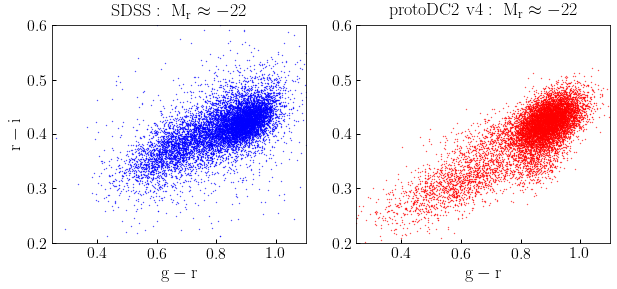

In [15]:
faint, bright = -21.5, -22.5

mask = (mock['restframe_extincted_sdss_abs_magr'] < faint) & (mock['restframe_extincted_sdss_abs_magr'] > bright)
from cosmodc2.sdss_colors.sdss_completeness_model import retrieve_sdss_sample_mask
sdss_mask = retrieve_sdss_sample_mask(sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], 
                          bright, faint)


num_sdss_sample = np.count_nonzero(sdss_mask)
num_mock_sample = np.count_nonzero(mask)
num_to_plot = int(min(num_sdss_sample, num_mock_sample)/2)

sdss_indices = np.random.choice(np.arange(num_sdss_sample), num_to_plot, replace=False)
sdss_sample_gr = sdss['restframe_extincted_sdss_gr'][sdss_mask][sdss_indices.astype(int)]
sdss_sample_ri = sdss['restframe_extincted_sdss_ri'][sdss_mask][sdss_indices.astype(int)]

mock_indices = np.random.choice(np.arange(num_mock_sample), num_to_plot, replace=False)
mock_sample_gr = mock['restframe_extincted_sdss_gr'][mask][mock_indices.astype(int)]
mock_sample_ri = mock['restframe_extincted_sdss_ri'][mask][mock_indices.astype(int)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

__=ax1.scatter(sdss_sample_gr, sdss_sample_ri, s=0.1, color='blue')
__=ax2.scatter(mock_sample_gr, mock_sample_ri, s=0.1, color='red')


xlim = ax1.set_xlim(0.25, 1.1)
ylim = ax1.set_ylim(0.2, 0.6)
xlim = ax2.set_xlim(0.25, 1.1)
ylim = ax2.set_ylim(0.2, 0.6)

xlabel = ax1.set_xlabel(r'${\rm g-r}$')
xlabel2 = ax2.set_xlabel(r'${\rm g-r}$')
ylabel = ax1.set_ylabel(r'${\rm r-i}$')
title1 = ax1.set_title(r'${\rm SDSS:\ M_r \approx -22}$')
title2 = ax2.set_title(r'${\rm protoDC2\ v4:\ M_r \approx -22}$')

figname = 'sdss_gr_ri_vs_magr22.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3], bbox_inches='tight')

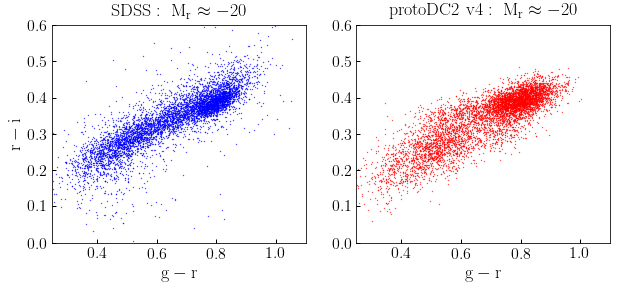

In [16]:
faint, bright = -19.5, -20.5

mask = (mock['restframe_extincted_sdss_abs_magr'] < faint) & (mock['restframe_extincted_sdss_abs_magr'] > bright)
from cosmodc2.sdss_colors.sdss_completeness_model import retrieve_sdss_sample_mask
sdss_mask = retrieve_sdss_sample_mask(sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], 
                          bright, faint)


num_sdss_sample = np.count_nonzero(sdss_mask)
num_mock_sample = np.count_nonzero(mask)
num_to_plot = int(min(num_sdss_sample, num_mock_sample)/2)

sdss_indices = np.random.choice(np.arange(num_sdss_sample), num_to_plot, replace=False)
sdss_sample_gr = sdss['restframe_extincted_sdss_gr'][sdss_mask][sdss_indices.astype(int)]
sdss_sample_ri = sdss['restframe_extincted_sdss_ri'][sdss_mask][sdss_indices.astype(int)]

mock_indices = np.random.choice(np.arange(num_mock_sample), num_to_plot, replace=False)
mock_sample_gr = mock['restframe_extincted_sdss_gr'][mask][mock_indices.astype(int)]
mock_sample_ri = mock['restframe_extincted_sdss_ri'][mask][mock_indices.astype(int)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

__=ax1.scatter(sdss_sample_gr, sdss_sample_ri, s=0.1, color='blue')
__=ax2.scatter(mock_sample_gr, mock_sample_ri, s=0.1, color='red')


xlim = ax1.set_xlim(0.25, 1.1)
ylim = ax1.set_ylim(0., 0.6)
xlim = ax2.set_xlim(0.25, 1.1)
ylim = ax2.set_ylim(0., 0.6)

xlabel = ax1.set_xlabel(r'${\rm g-r}$')
xlabel2 = ax2.set_xlabel(r'${\rm g-r}$')
ylabel = ax1.set_ylabel(r'${\rm r-i}$')
title1 = ax1.set_title(r'${\rm SDSS:\ M_r \approx -20}$')
title2 = ax2.set_title(r'${\rm protoDC2\ v4:\ M_r \approx -20}$')

figname = 'sdss_gr_ri_vs_magr20.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3], bbox_inches='tight')

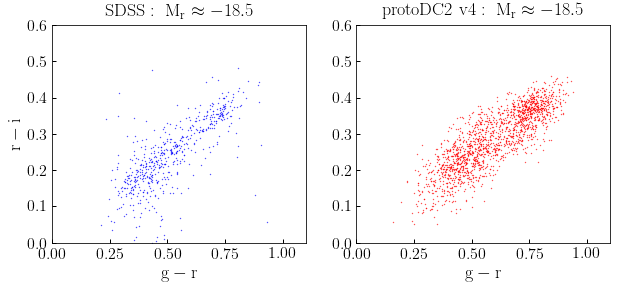

In [17]:
faint, bright = -18.0, -19.0

mask = (mock['restframe_extincted_sdss_abs_magr'] < faint) & (mock['restframe_extincted_sdss_abs_magr'] > bright)
from cosmodc2.sdss_colors.sdss_completeness_model import retrieve_sdss_sample_mask
sdss_mask = retrieve_sdss_sample_mask(sdss['z'], sdss['restframe_extincted_sdss_abs_magr'], 
                          bright, faint)


num_sdss_sample = np.count_nonzero(sdss_mask)
num_mock_sample = np.count_nonzero(mask)
num_to_plot = int(min(num_sdss_sample, num_mock_sample)/2)

sdss_indices = np.random.choice(np.arange(num_sdss_sample), num_to_plot, replace=False)
sdss_sample_gr = sdss['restframe_extincted_sdss_gr'][sdss_mask][sdss_indices.astype(int)]
sdss_sample_ri = sdss['restframe_extincted_sdss_ri'][sdss_mask][sdss_indices.astype(int)]

num_to_plot_mock = 3*num_to_plot
mock_indices = np.random.choice(np.arange(num_mock_sample), num_to_plot_mock, replace=False)
mock_sample_gr = mock['restframe_extincted_sdss_gr'][mask][mock_indices.astype(int)]
mock_sample_ri = mock['restframe_extincted_sdss_ri'][mask][mock_indices.astype(int)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

__=ax1.scatter(sdss_sample_gr, sdss_sample_ri, s=0.1, color='blue')
__=ax2.scatter(mock_sample_gr, mock_sample_ri, s=0.1, color='red')


xlim = ax1.set_xlim(0., 1.1)
ylim = ax1.set_ylim(0., 0.6)
xlim = ax2.set_xlim(0., 1.1)
ylim = ax2.set_ylim(0., 0.6)

xlabel = ax1.set_xlabel(r'${\rm g-r}$')
xlabel2 = ax2.set_xlabel(r'${\rm g-r}$')
ylabel = ax1.set_ylabel(r'${\rm r-i}$')
title1 = ax1.set_title(r'${\rm SDSS:\ M_r \approx -18.5}$')
title2 = ax2.set_title(r'${\rm protoDC2\ v4:\ M_r \approx -18.5}$')

figname = 'sdss_gr_ri_vs_magr18.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3], bbox_inches='tight')

##  Cluster halo colors

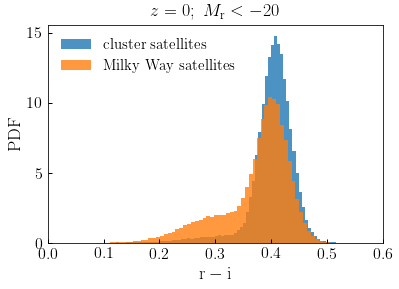

In [18]:
magr_mask = mock['restframe_extincted_sdss_abs_magr'] < -20
cenmask = mock['upid'] == -1
cluster_halo_mask = mock['host_halo_mvir'] > 10**14
mw_halo_mask = (mock['host_halo_mvir'] > 10**12) & (mock['host_halo_mvir'] < 10**12.5)

fig, ax = plt.subplots(1, 1)

nbins = 80
__=ax.hist(mock['restframe_extincted_sdss_ri'][~cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm cluster\ satellites}$')
__=ax.hist(mock['restframe_extincted_sdss_ri'][~cenmask & mw_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm Milky\ Way\ satellites}$')

legend = ax.legend()
xlim1 = ax.set_xlim(0, 0.6)
xlabel = ax.set_xlabel(r'${\rm r-i}$')
ylabel = ax.set_ylabel(r'${\rm PDF}$')
_title = r'$z=0;\ M_{\rm r}<-20$'
title = ax.set_title(_title)


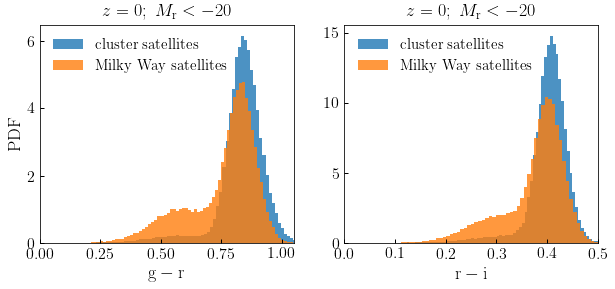

In [19]:
magr_mask = mock['restframe_extincted_sdss_abs_magr'] < -20
cenmask = mock['upid'] == -1
cluster_halo_mask = mock['host_halo_mvir'] > 10**14
mw_halo_mask = (mock['host_halo_mvir'] > 10**12) & (mock['host_halo_mvir'] < 10**12.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

nbins = 80
__=ax1.hist(mock['restframe_extincted_sdss_gr'][~cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm cluster\ satellites}$')
__=ax1.hist(mock['restframe_extincted_sdss_gr'][~cenmask & mw_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm Milky\ Way\ satellites}$')

__=ax2.hist(mock['restframe_extincted_sdss_ri'][~cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm cluster\ satellites}$')
__=ax2.hist(mock['restframe_extincted_sdss_ri'][~cenmask & mw_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'${\rm Milky\ Way\ satellites}$')


legend1 = ax1.legend()
xlim1 = ax1.set_xlim(0, 1.05)
xlabel1 = ax1.set_xlabel(r'${\rm g-r}$')
ylabel1 = ax1.set_ylabel(r'${\rm PDF}$')
_title1 = r'$z=0;\ M_{\rm r}<-20$'
title1 = ax1.set_title(_title1)

legend = ax2.legend()
xlim2 = ax2.set_xlim(0, 0.5)
xlabel2 = ax2.set_xlabel(r'${\rm r-i}$')
_title2 = r'$z=0;\ M_{\rm r}<-20$'
title2 = ax2.set_title(_title2)

figname = 'halo_mass_quenching_satellites.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')

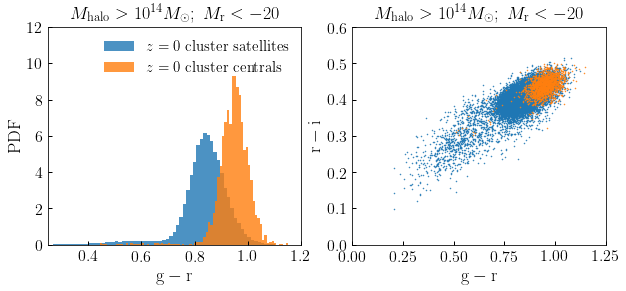

In [20]:
magr_mask = mock['restframe_extincted_sdss_abs_magr'] < -20
cenmask = mock['upid'] == -1
cluster_halo_mask = mock['host_halo_mvir'] > 10**14


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

nbins = 80
__=ax1.hist(mock['restframe_extincted_sdss_gr'][~cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'$z=0\ {\rm cluster\ satellites}$')
__=ax1.hist(mock['restframe_extincted_sdss_gr'][cenmask & cluster_halo_mask & magr_mask], 
               bins=nbins, normed=True, alpha=0.8, 
              label=r'$z=0\ {\rm cluster\ centrals}$')


legend = ax1.legend()
xlim1 = ax1.set_xlim(0.25, 1.2)
ylim1 = ax1.set_ylim(0, 12)
xlabel1 = ax1.set_xlabel(r'${\rm g-r}$')
ylabel1 = ax1.set_ylabel(r'${\rm PDF}$')
_title = r'$M_{\rm halo}>10^{14}M_{\odot};\ M_{\rm r}<-20$'
title1 = ax1.set_title(_title)

nskip = 5
__=ax2.scatter(
    mock['restframe_extincted_sdss_gr'][~cenmask & cluster_halo_mask & magr_mask][::nskip],
    mock['restframe_extincted_sdss_ri'][~cenmask & cluster_halo_mask & magr_mask][::nskip], 
    s=0.25, label=r'${\rm cluster\ satellites}$')
nskip = 2
__=ax2.scatter(
    mock['restframe_extincted_sdss_gr'][cenmask & cluster_halo_mask & magr_mask][::nskip],
    mock['restframe_extincted_sdss_ri'][cenmask & cluster_halo_mask & magr_mask][::nskip], 
    s=0.25, label=r'${\rm cluster\ centrals}$')

xlim2 = ax2.set_xlim(0., 1.25)
ylim2 = ax2.set_ylim(0., 0.6)
xlabel2 = ax2.set_xlabel(r'${\rm g-r}$')
ylabel2 = ax2.set_ylabel(r'${\rm r-i}$')
_title = r'$M_{\rm halo}>10^{14}M_{\odot};\ M_{\rm r}<-20$'
title2 = ax2.set_title(_title)

figname = 'cluster_halo_colors_v4.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')

## Compare color-dependent clustering to Zehavi+11

In [21]:
from cosmodc2.sdss_colors import zehavi11_clustering
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi

wp_blue18p0, wperr_blue18p0 = zehavi11_clustering(-18.0, subsample='blue')
wp_red18p0, wperr_red18p0 = zehavi11_clustering(-18.0, subsample='red')

wp_blue18p5, wperr_blue18p5 = zehavi11_clustering(-18.5, subsample='blue')
wp_red18p5, wperr_red18p5 = zehavi11_clustering(-18.5, subsample='red')

wp_blue19p0, wperr_blue19p0 = zehavi11_clustering(-19, subsample='blue')
wp_red19p0, wperr_red19p0 = zehavi11_clustering(-19, subsample='red')

wp_blue19p5, wperr_blue19p5 = zehavi11_clustering(-19.5, subsample='blue')
wp_red19p5, wperr_red19p5 = zehavi11_clustering(-19.5, subsample='red')

wp_blue20p0, wperr_blue20p0 = zehavi11_clustering(-20, subsample='blue')
wp_red20p0, wperr_red20p0 = zehavi11_clustering(-20, subsample='red')

wp_blue20p5, wperr_blue20p5 = zehavi11_clustering(-20.5, subsample='blue')
wp_red20p5, wperr_red20p5 = zehavi11_clustering(-20.5, subsample='red')

wp_blue21p5, wperr_blue21p5 = zehavi11_clustering(-21.5, subsample='blue')
wp_red21p5, wperr_red21p5 = zehavi11_clustering(-21.5, subsample='red')

wp_blue22p0, wperr_blue22p0 = zehavi11_clustering(-22.0, subsample='blue')
wp_red22p0, wperr_red22p0 = zehavi11_clustering(-22.0, subsample='red')


In [22]:
from cosmodc2.mock_diagnostics import zehavi_wp

protoDC2_littleh = 0.7
period = mock.Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['restframe_extincted_sdss_abs_magr']

rp_mids, wp_v4_18p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -18.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_18p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -18.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])


...calculating wp for 4.01e+05 galaxies and Mr < -18.0
...calculating wp for 4.00e+05 galaxies and Mr < -18.0


In [23]:
rp_mids, wp_v4_20p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -20.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_20p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -20.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])


...calculating wp for 3.59e+05 galaxies and Mr < -20.0
...calculating wp for 4.00e+05 galaxies and Mr < -20.0


In [24]:
rp_mids, wp_v4_18p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -18.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_18p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -18.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_18p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -18.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_18p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -18.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_20p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -20.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_20p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -20.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_22p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -22.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_22p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -22.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])


...calculating wp for 4.00e+05 galaxies and Mr < -18.0
...calculating wp for 4.01e+05 galaxies and Mr < -18.0
...calculating wp for 4.00e+05 galaxies and Mr < -18.5
...calculating wp for 3.99e+05 galaxies and Mr < -18.5
...calculating wp for 3.59e+05 galaxies and Mr < -20.0
...calculating wp for 4.00e+05 galaxies and Mr < -20.0
...calculating wp for 2.71e+03 galaxies and Mr < -22.0
...calculating wp for 1.66e+04 galaxies and Mr < -22.0


In [25]:
from cosmodc2.mock_diagnostics import zehavi_wp

protoDC2_littleh = 0.7

period = mock.Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']
magr = mock['restframe_extincted_sdss_abs_magr']

rp_mids, wp_v4_19p0_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_19p0_red = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_19p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_19p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_20p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_20p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_21p5_blue = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='blue', gr_colors=mock['restframe_extincted_sdss_gr'])

rp_mids, wp_v4_21p5_red = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh, 
            subsample='red', gr_colors=mock['restframe_extincted_sdss_gr'])

...calculating wp for 4.01e+05 galaxies and Mr < -19.0
...calculating wp for 3.99e+05 galaxies and Mr < -19.0
...calculating wp for 4.00e+05 galaxies and Mr < -19.5
...calculating wp for 4.00e+05 galaxies and Mr < -19.5
...calculating wp for 1.62e+05 galaxies and Mr < -20.5
...calculating wp for 2.54e+05 galaxies and Mr < -20.5
...calculating wp for 1.34e+04 galaxies and Mr < -21.5
...calculating wp for 5.37e+04 galaxies and Mr < -21.5


### Plot the results

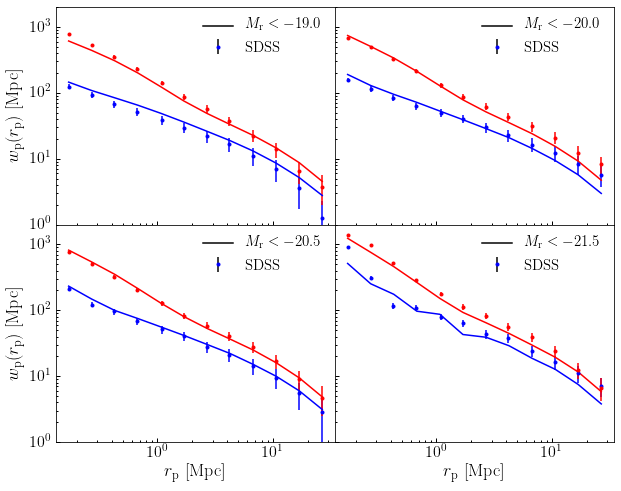

In [26]:
fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)  #  smash top and bottom plots
fig.subplots_adjust(wspace=0)  #  smash left and right plots

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()

# __=ax1.errorbar(rp_zehavi, wp_blue18p0, np.sqrt(wperr_blue19p0), 
#                 fmt='.', color='blue', label=r'${\rm SDSS}$')
# __=ax1.errorbar(rp_zehavi, wp_red18p0, np.sqrt(wperr_red19p0), 
#                 fmt='.', color='red')
# __=ax1.plot(rp_mids, wp_v4_18p0_blue, color='blue', label=r'$M_{\rm r} < -18.0$')
# __=ax1.plot(rp_mids, wp_v4_18p0_red, color='red')

# __=ax1.errorbar(rp_zehavi, wp_blue18p5, np.sqrt(wperr_blue19p5), 
#                 fmt='.', color='blue', label=r'${\rm SDSS}$')
# __=ax1.errorbar(rp_zehavi, wp_red18p5, np.sqrt(wperr_red19p5), 
#                 fmt='.', color='red')
# __=ax1.plot(rp_mids, wp_v4_18p5_blue, color='blue', label=r'$M_{\rm r} < -18.5$')
# __=ax1.plot(rp_mids, wp_v4_18p5_red, color='red')

__=ax1.errorbar(rp_zehavi, wp_blue19p0, np.sqrt(wperr_blue19p0), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax1.errorbar(rp_zehavi, wp_red19p0, np.sqrt(wperr_red19p0), 
                fmt='.', color='red')
__=ax1.plot(rp_mids, wp_v4_19p0_blue, color='blue', label=r'$M_{\rm r} < -19.0$')
__=ax1.plot(rp_mids, wp_v4_19p0_red, color='red')


__=ax2.errorbar(rp_zehavi, wp_blue20p0, np.sqrt(wperr_blue20p0), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax2.errorbar(rp_zehavi, wp_red20p0, np.sqrt(wperr_red20p0), 
                fmt='.', color='red')
__=ax2.plot(rp_mids, wp_v4_20p0_blue, color='blue', label=r'$M_{\rm r} < -20.0$')
__=ax2.plot(rp_mids, wp_v4_20p0_red, color='red')

__=ax3.errorbar(rp_zehavi, wp_blue20p5, np.sqrt(wperr_blue20p5), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax3.errorbar(rp_zehavi, wp_red20p5, np.sqrt(wperr_red20p5), 
                fmt='.', color='red')
__=ax3.plot(rp_mids, wp_v4_20p5_blue, color='blue', label=r'$M_{\rm r} < -20.5$')
__=ax3.plot(rp_mids, wp_v4_20p5_red, color='red')

__=ax4.errorbar(rp_zehavi, wp_blue21p5, np.sqrt(wperr_blue21p5), 
                fmt='.', color='blue', label=r'${\rm SDSS}$')
__=ax4.errorbar(rp_zehavi, wp_red21p5, np.sqrt(wperr_red21p5), 
                fmt='.', color='red')
__=ax4.plot(rp_mids, wp_v4_21p5_blue, color='blue', label=r'$M_{\rm r} < -21.5$')
__=ax4.plot(rp_mids, wp_v4_21p5_red, color='red')


xlabel3 = ax3.set_xlabel(r'${r_{\rm p}\ [{\rm Mpc}]}$')
xlabel4 = ax4.set_xlabel(r'${r_{\rm p}\ [{\rm Mpc}]}$')

ylabel1 = ax1.set_ylabel(r'$w_{\rm p}({r_{\rm p})\ [{\rm Mpc}]}$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}({r_{\rm p})\ [{\rm Mpc}]}$')

for ax in axes:
    leg = ax.legend()
    leg.legendHandles[0].set_color('k')
    leg.legendHandles[1].set_color('k')
    
ylim = ax1.set_ylim(1, 2000)
figname = 'v4_color_dependent_clustering_vs_zehavi11.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')